In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.signal import correlate, fftconvolve, correlate
from scipy.stats import norm, kendalltau, spearmanr, pearsonr
from scipy.optimize import curve_fit
from tqdm import tqdm

In [2]:
def shift_array(arr, n, fill_value=0):
    """Shift an array by n elements (left or right)."""
    result = np.empty_like(arr)
    if n > 0:
        result[:n] = fill_value
        result[n:] = arr[:-n]
    elif n < 0:
        result[n:] = fill_value
        result[:n] = arr[-n:]
    else:
        result[:] = arr
    return result


def detect_molecule(wavelength, spectrum, specie_spectrum, clip_min=4.9, clip_max=27.5, peak_shift=0, window=300, exclude=20):
    if len(wavelength) != len(spectrum) | len(wavelength) != len(specie_spectrum):
        print('Error: wavelength, spectrum and specie_spectrum must be the same length')
        return

    feature_mask = np.logical_and(wavelength > clip_min, wavelength < clip_max)

    # center_index = len(wavelength[feature_mask]) // 2

    lags = np.arange(-len(spectrum[feature_mask]) + 1, len(spectrum[feature_mask]))
    cc = correlate(spectrum[feature_mask], specie_spectrum[feature_mask], mode='full')
    ac = correlate(specie_spectrum[feature_mask], specie_spectrum[feature_mask], mode='full')
    ac /= ac[len(ac)//2]
    center_index = len(lags) // 2
    lag_indices = np.arange(center_index - window, center_index + window + 1)


    X = ac[lag_indices]
    Y = cc[lag_indices]
    X = shift_array(X, peak_shift)

    print(len(ac))
    model = cc[center_index + peak_shift] * X
    residual = Y - model

    lags_window = lags[lag_indices] - lags[center_index + peak_shift]
    print(lags_window)
    noise_mask = (lags_window < -exclude) | (lags_window > exclude)
    sigma_noise = np.std(residual[noise_mask])

    Z = cc[center_index + peak_shift] / sigma_noise
    p = 1 - norm.cdf(Z)
    plt.plot(lags_window, Y, label='Cross-correlation')
    plt.plot(lags_window, model, label='Fitted tiny signal')
    plt.plot(lags_window, residual, label='Residual')
    plt.axvline(0, color='gray', linestyle='--', label='Lag=0')
    plt.axhline(0, color='gray', linestyle=':')
    plt.title(f'Cross-correlation Analysis\nZ-score at lag=0 = {Z:.2f}')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(True)
    return Z, p

def new_detect_molecule(wavelength, spectrum, specie_spectrum, clip_min=4.9, clip_max=27.5, peak_shift=0, window=300,
                    exclude=20, title=None, plot=False, n_trials=1000):
    if len(wavelength) != len(spectrum) | len(wavelength) != len(specie_spectrum):
        print('Error: wavelength, spectrum and specie_spectrum must be the same length')
        return

    feature_mask = np.logical_and(wavelength > clip_min, wavelength < clip_max)

    # center_index = len(wavelength[feature_mask]) // 2

    lags = np.arange(-len(spectrum[feature_mask]) + 1, len(spectrum[feature_mask]))
    cc = correlate(spectrum[feature_mask], specie_spectrum[feature_mask], mode='full')
    ac = correlate(specie_spectrum[feature_mask], specie_spectrum[feature_mask], mode='full')
    ac /= ac[len(ac) // 2]
    center_index = len(lags) // 2
    lag_indices = np.arange(center_index - window, center_index + window + 1)

    # plt.plot(correlate(ac, cc))
    # plt.show()
    X = ac[lag_indices]
    Y = cc[lag_indices]
    X = shift_array(X, peak_shift)
    # print(pearsonr(X, Y))
    lags_window = lags[lag_indices] - lags[center_index + peak_shift]
    noise_mask = (lags_window < -exclude) | (lags_window > exclude)

    weights = np.exp(-(lags_window) ** 2 / 2)
    # print(weights)
    factor = np.sum(X[~noise_mask]*Y[~noise_mask])/np.sum(X[~noise_mask]**2)
    model = factor * X
    residual = Y - model

    mid = len(Y) // 2
    test_s = Y[mid]-np.median(Y[~noise_mask])
    test_s_list = []
    for _ in range(n_trials):
        # shift = np.random.randint(1, len(spectrum[feature_mask]))  # avoid shift = 0
        # spectrum_shifted = np.roll(spectrum[feature_mask], shift)
        cc_new = correlate(np.random.choice(spectrum[feature_mask], size=len(spectrum[feature_mask]), replace=True), specie_spectrum[feature_mask], mode='full')
        # factor = np.sum(X[~noise_mask]*cc_new[lag_indices][~noise_mask])/np.sum(X[~noise_mask]**2)
        # model = factor * X
        # plt.plot(lags[lag_indices], cc_new[lag_indices])
        # plt.plot(lags[lag_indices], cc[lag_indices])
        # plt.show()
        test_s_list.append(cc_new[lag_indices][mid]-np.median(cc_new[lag_indices][~noise_mask]))
    test_s_list = np.array(test_s_list)
    p = round(1 - len(test_s_list[test_s_list<test_s])/n_trials, int(np.log10(n_trials)))
    if plot:
        plt.plot(lags_window, Y, label='Cross-correlation')
        plt.plot(lags_window, X*Y[mid], label='Fitted Auto-correlation')
        # plt.plot(lags_window, residual, label='Residual')
        plt.axvline(peak_shift, color='gray', linestyle='--', label='Peak')
        plt.axhline(0, color='gray', linestyle=':')
        plt.axvline(-exclude, color='red', linestyle='--')
        plt.axvline(exclude, color='red', linestyle='--', label='Window')
        plt.title(f'Cross-correlation {title}')
        plt.xlabel('Lag')
        plt.ylabel('Correlation')
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.xlim(-window, window)
        plt.grid(True)
        plt.show()
        plt.title(title + ' ' + str(p))
        plt.hist(test_s_list, density=True)
        plt.axvline(test_s, color='red')
        plt.xlabel('Difference Peak and Median')
        plt.ylabel('Probability Density')
        plt.show()
    return p

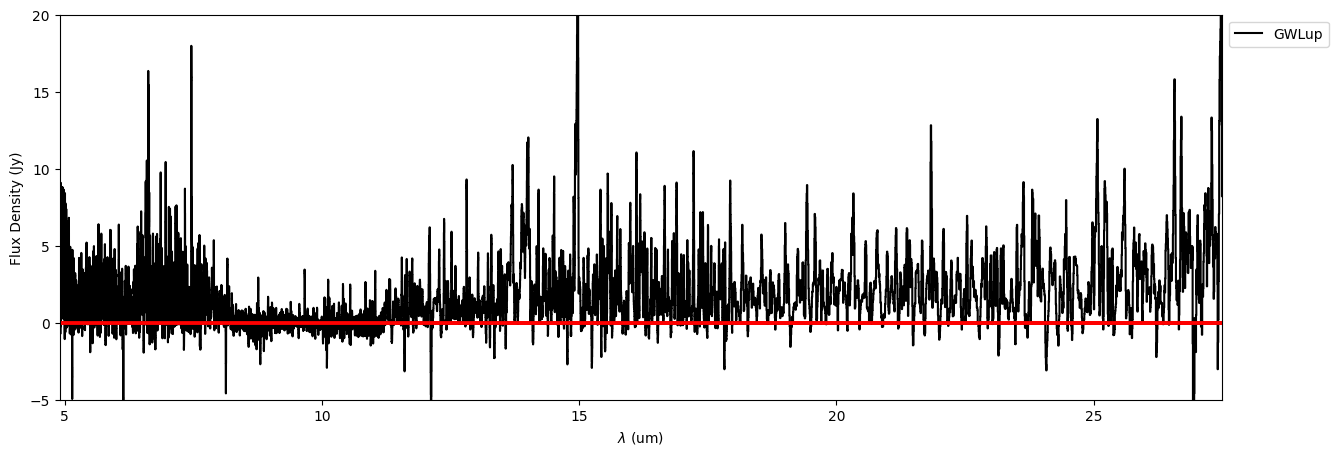

10657


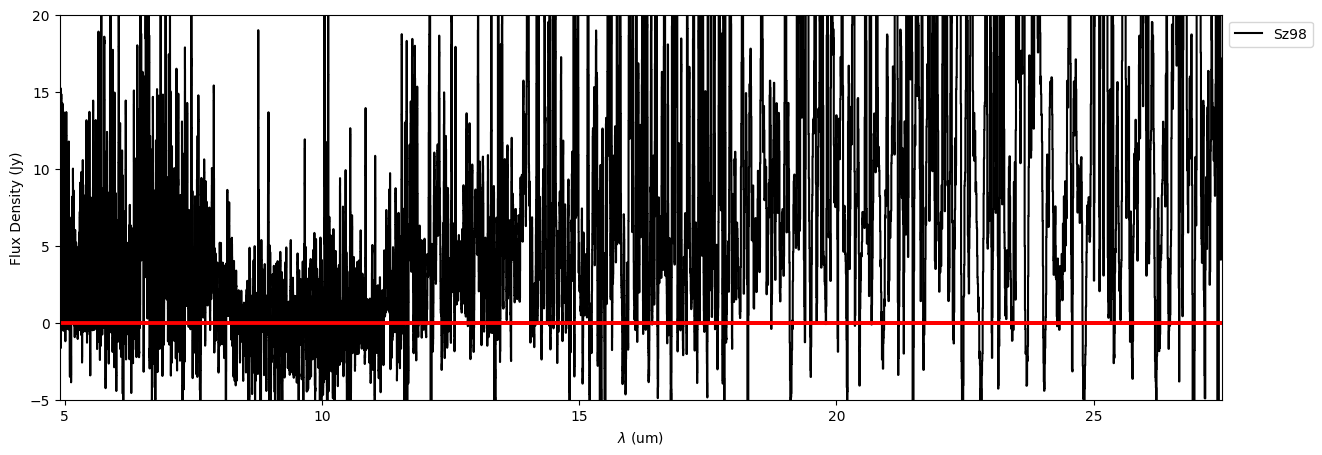

10657


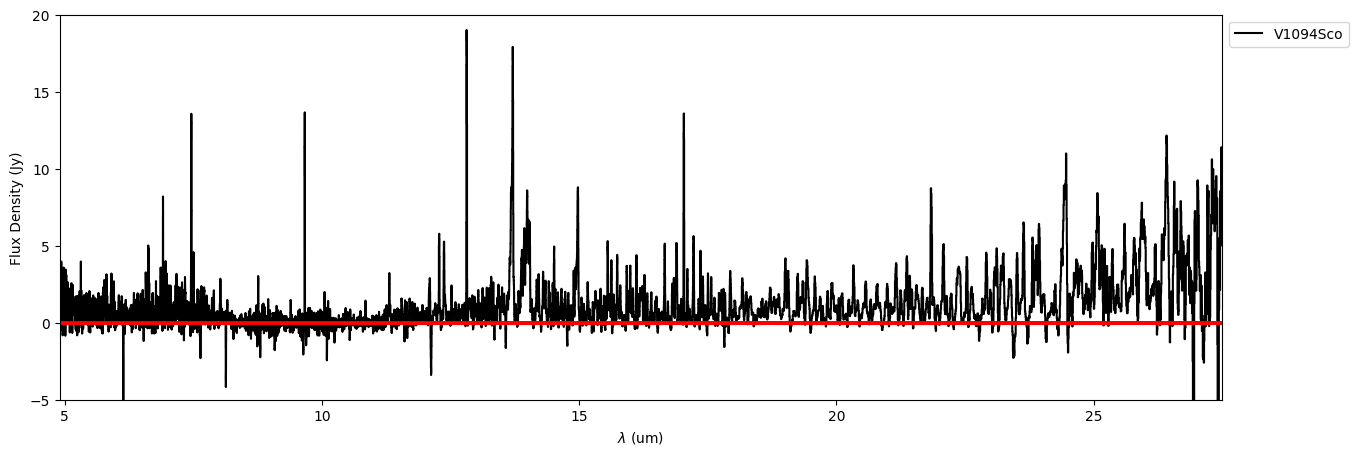

10657


In [3]:
features_df = pd.read_csv("matthias_linelist_combined.csv")

# Wavelength grid
clip_min, clip_max = 4.9, 27.5
feature_mask = np.logical_and(features_df['wavelength'] > clip_min, features_df['wavelength'] < clip_max)

species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']

# fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
for Source in ['GWLup', 'Sz98', 'V1094Sco']:
    fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
    file = f'FullSpectrum_CS_{Source}.p'
    data = pickle.load(open(file, 'rb'))
    wavelength = data['Wavelength']
    flux = data['Flux']
    flux_cont_sub = data['CSFlux']
    continuum = data['Baseline']
    ax1.step(wavelength, np.convolve(flux_cont_sub, np.ones(5)/5, mode='same')*1000, color='black',where='mid', label=f'{Source}')
    for index, row in features_df[feature_mask].iterrows():
        if row['type'] == 'hydrogen':
            color = 'purple'
            offset = 0.05
        elif row['type'] == 'fine_structure':
            color = 'orange'
            offset = 0.4
        elif row['type'] == 'molecular':
            color = 'blue'
            offset = 0.05
        else:
            color = 'red'
            offset = 0.6
        ax1.axhline(0,  color='red')
        # ax1.axvline(row['wavelength'], linestyle='--', alpha=0.3, color=color)
        # ax1.text(row['wavelength']+0.004, offset, row['name'], transform=ax1.get_xaxis_text1_transform(0)[0], color=color, rotation=90)

    # for specie in species:
    #     ax1.plot(total_wl, avg_flux[specie], alpha=0.7, label=specie)

    # plot decorations
    # ax1.set_xticks([14.9, 14.95, 15])
    ax1.set_xlim(clip_min, clip_max)    
    ax1.set_ylabel('Flux Density (Jy)')
    ax1.set_xlabel(r'$\lambda$ (um)')
    ax1.set_ylim(-5, 20)
    
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    print(len(wavelength))

In [4]:
with open('FLiTsData1000_N.pkl', 'rb') as f:
    df = pickle.load(f)

In [5]:
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
avg_flux = {}
total_wl = wavelength
for specie in species:
    total_flux = np.zeros_like(total_wl)
    for i,row in df.iterrows():
        specie_wl = row[f'FLiTs {specie} Wavelength']
        specie_flux = row[f'FLiTs {specie} Flux']
        specie_flux = np.interp(total_wl, specie_wl, specie_flux)
        total_flux += specie_flux
    total_flux /= 25
    avg_flux.update({specie:total_flux})

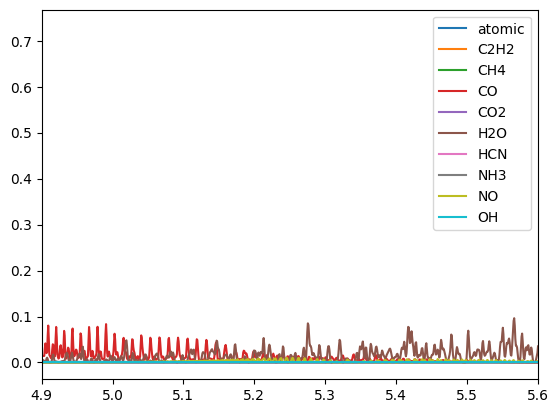

In [6]:
for specie in species:
    plt.plot(total_wl, avg_flux[specie], label=specie)
plt.legend()
plt.xlim(4.9, 5.6)
plt.show()

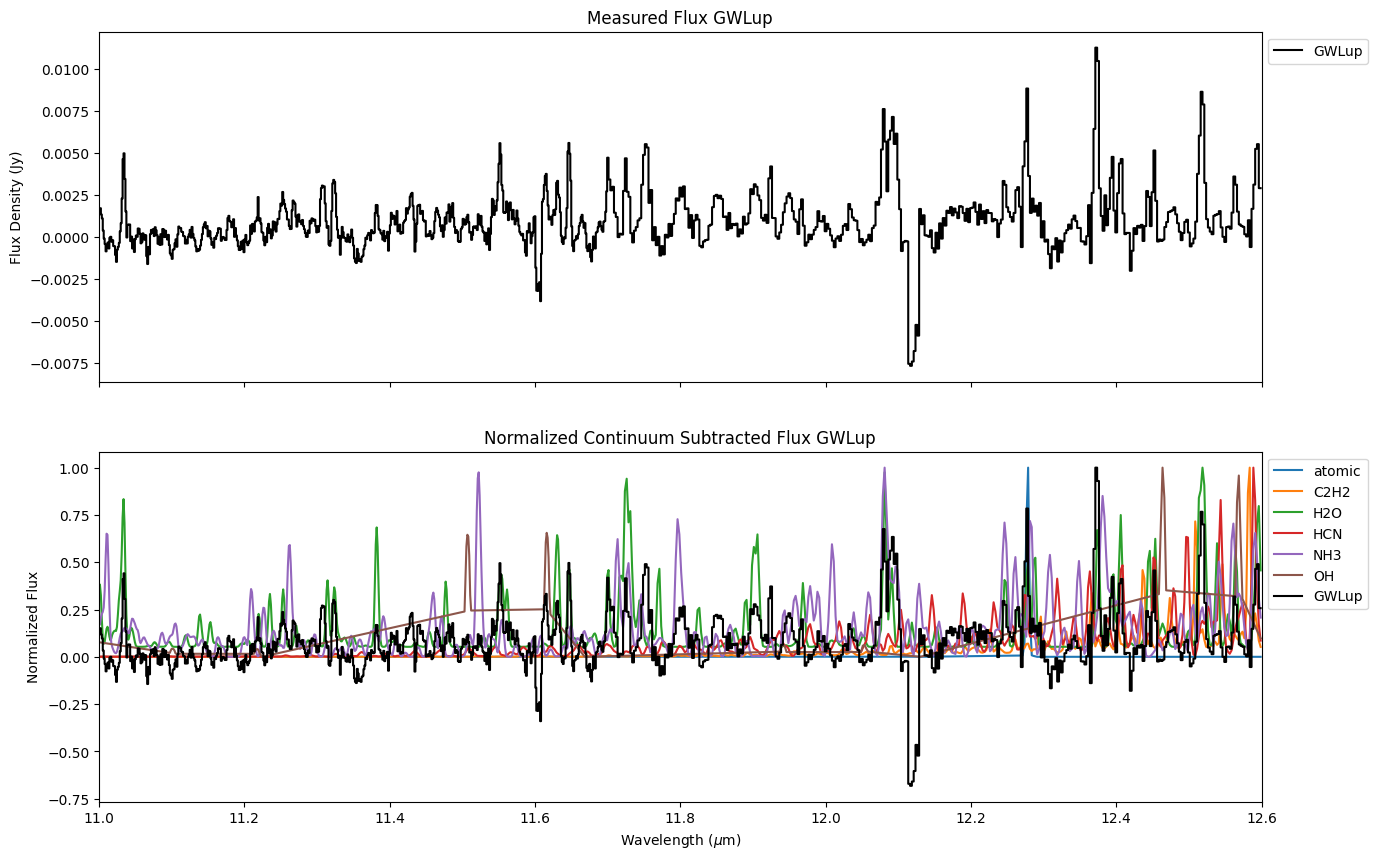

C:\Users\Niels de Klerk\AppData\Local\Temp\ipykernel_15564\3338619039.py:77: RuntimeWarning: invalid value encountered in divide
  plt.plot(lags, cc/max(cc))
C:\Users\Niels de Klerk\AppData\Local\Temp\ipykernel_15564\3338619039.py:78: RuntimeWarning: invalid value encountered in divide
  plt.plot(lags, ac_specie/ac_specie[lags==0])


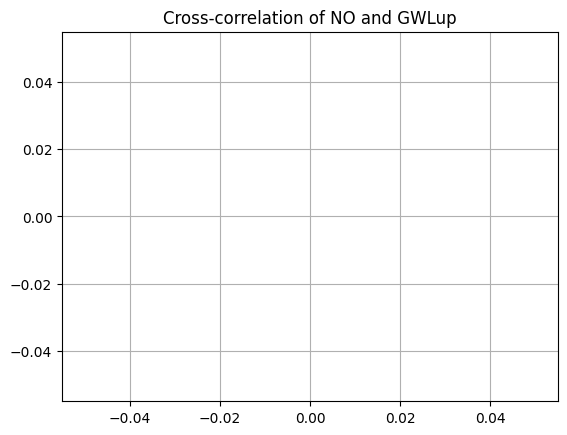

C:\Users\Niels de Klerk\AppData\Local\Temp\ipykernel_15564\3338619039.py:83: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  print(pearsonr(cc, ac_specie))


PearsonRResult(statistic=np.float64(nan), pvalue=np.float64(nan))


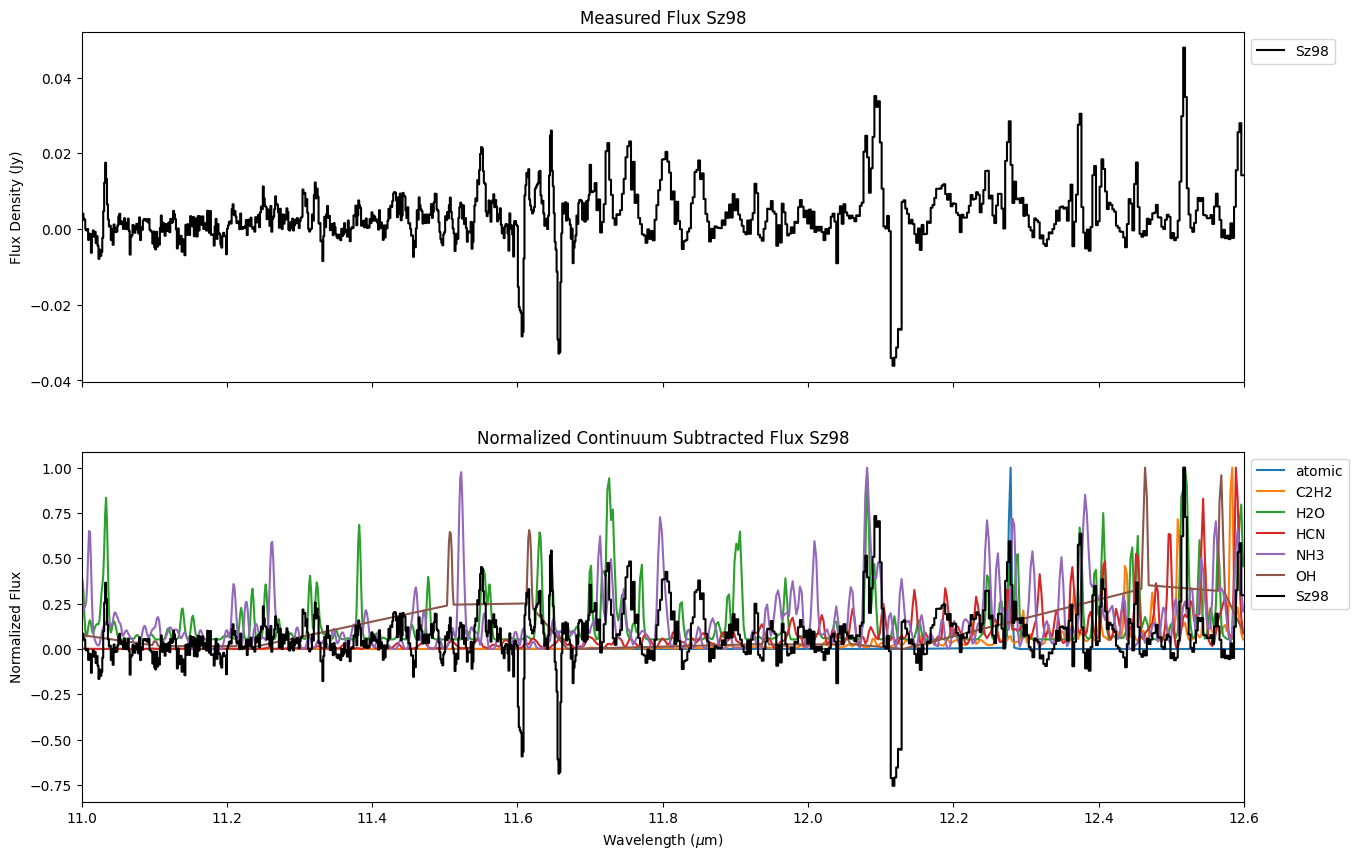

C:\Users\Niels de Klerk\AppData\Local\Temp\ipykernel_15564\3338619039.py:77: RuntimeWarning: invalid value encountered in divide
  plt.plot(lags, cc/max(cc))
C:\Users\Niels de Klerk\AppData\Local\Temp\ipykernel_15564\3338619039.py:78: RuntimeWarning: invalid value encountered in divide
  plt.plot(lags, ac_specie/ac_specie[lags==0])


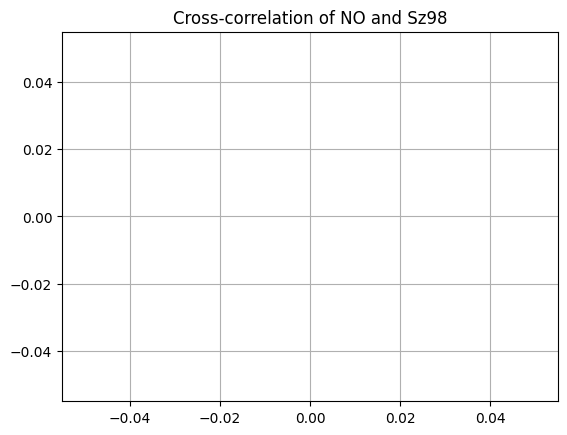

C:\Users\Niels de Klerk\AppData\Local\Temp\ipykernel_15564\3338619039.py:83: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  print(pearsonr(cc, ac_specie))


PearsonRResult(statistic=np.float64(nan), pvalue=np.float64(nan))


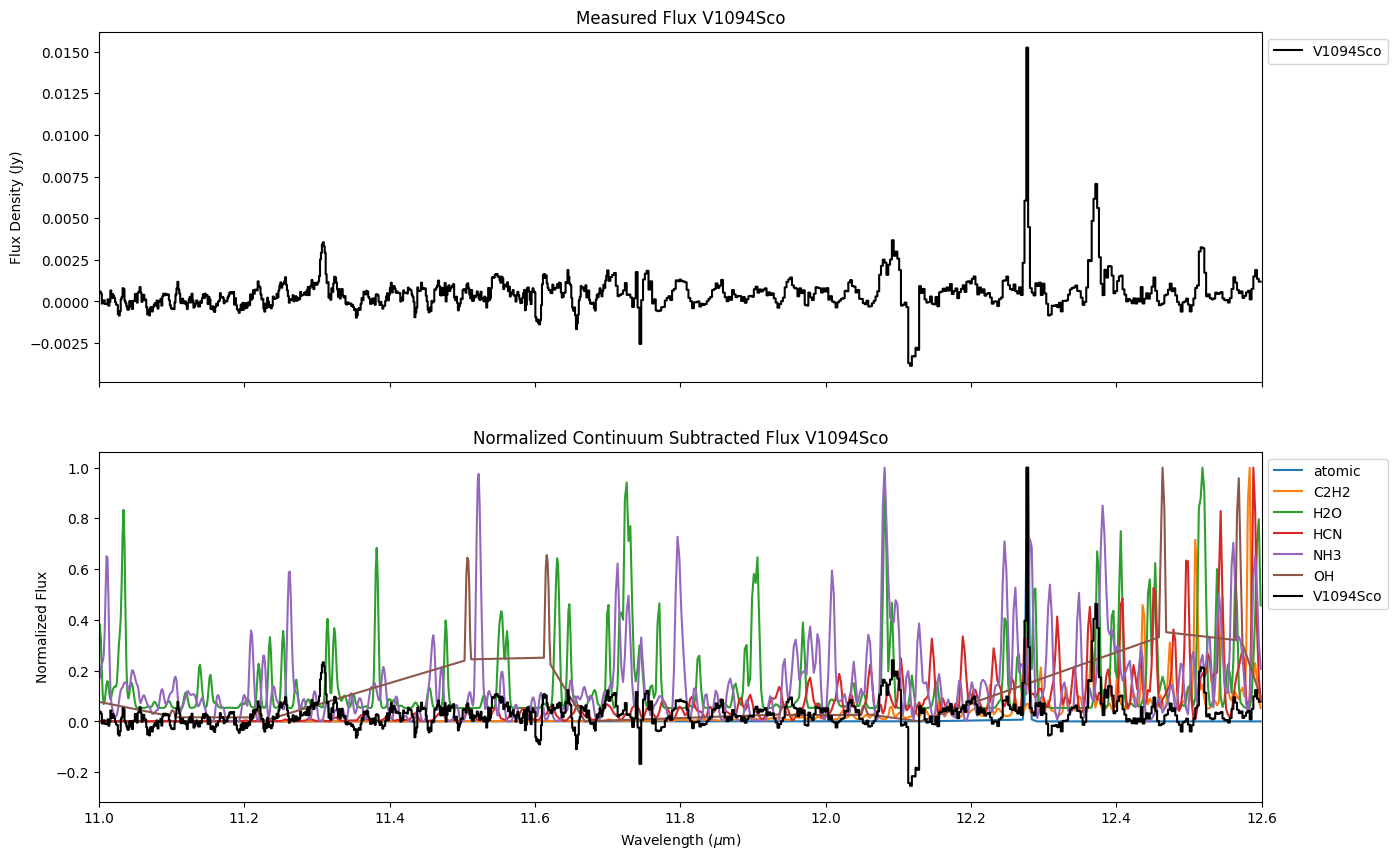

C:\Users\Niels de Klerk\AppData\Local\Temp\ipykernel_15564\3338619039.py:77: RuntimeWarning: invalid value encountered in divide
  plt.plot(lags, cc/max(cc))
C:\Users\Niels de Klerk\AppData\Local\Temp\ipykernel_15564\3338619039.py:78: RuntimeWarning: invalid value encountered in divide
  plt.plot(lags, ac_specie/ac_specie[lags==0])


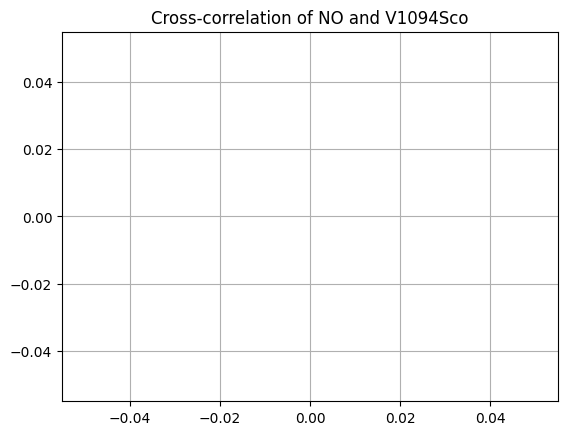

PearsonRResult(statistic=np.float64(nan), pvalue=np.float64(nan))


C:\Users\Niels de Klerk\AppData\Local\Temp\ipykernel_15564\3338619039.py:83: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  print(pearsonr(cc, ac_specie))


In [19]:
from scipy.optimize import minimize

clip_min, clip_max = 11, 12.6
feature_mask = np.logical_and(total_wl > clip_min, total_wl < clip_max)

species = ['atomic', 'C2H2', 'H2O', 'HCN', 'NH3', 'OH']
# species = ['C2H2', 'H2O', 'HCN', 'NH3', 'OH']
# species = ['NO', 'H2O', 'HCN']


def model(params):
    total = np.zeros_like(total_wl)
    for i, specie in enumerate(species):
        total += params[i] * avg_flux[specie]
    # total += params[-1]
    return total


def loss(params):
    if any(param < 0 for param in params):
        return 1e10
    return np.sum((model(params) - flux_cont_sub)[feature_mask] ** 2)


target = 'NO'

for Source in ['GWLup', 'Sz98', 'V1094Sco']:
    file = f'FullSpectrum_CS_{Source}.p'
    data = pickle.load(open(file, 'rb'))
    wavelength = data['Wavelength']
    flux = data['Flux']
    flux_cont_sub = data['CSFlux']
    continuum = data['Baseline']

    result = minimize(loss, [.1] * (len(species)))
    best_params = result.x
    # print(best_params)
    y_fit = model(best_params)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    # plt.figure(figsize=(15, 5))
    # ax1.plot(wavelength, model(best_params), color='red')
    # for i, specie in enumerate(species):
    #     ax1.plot(total_wl[feature_mask], best_params[i]*avg_flux[specie][feature_mask], alpha=0.7, label=specie)
    ax1.step(wavelength[feature_mask], flux_cont_sub[feature_mask], color='black', label=Source)
    ax1.set_xlim(clip_min, clip_max)
    ax1.set_ylabel('Flux Density (Jy)')
    ax1.set_title(f'Measured Flux {Source}')
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # plt.show()
    # plt.figure(figsize=(15, 5))
    for specie in species:
        ax2.plot(total_wl[feature_mask], avg_flux[specie][feature_mask] / max(avg_flux[specie][feature_mask]),
                 label=specie)
    ax2.step(wavelength[feature_mask], flux_cont_sub[feature_mask] / max(flux_cont_sub[feature_mask]), color='black',
             label=Source)
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax2.set_xlabel(r'Wavelength ($\mu$m)')
    ax2.set_ylabel('Normalized Flux')
    ax2.set_title(f'Normalized Continuum Subtracted Flux {Source}')
    plt.show()
    cc = fftconvolve((flux_cont_sub[feature_mask] - np.mean(flux_cont_sub[feature_mask])),
                     (avg_flux[target][feature_mask] - np.mean(avg_flux[target][feature_mask]))[::-1], mode='full')
    ac_specie = fftconvolve((avg_flux[target][feature_mask] - np.mean(avg_flux[target][feature_mask])),
                            (avg_flux[target][feature_mask] - np.mean(avg_flux[target][feature_mask]))[::-1],
                            mode='full')
    ac_total = fftconvolve((flux_cont_sub[feature_mask] - np.mean(flux_cont_sub[feature_mask])),
                           (flux_cont_sub[feature_mask] - np.mean(flux_cont_sub[feature_mask]))[::-1], mode='full')
    # cc = fftconvolve((flux_cont_sub[feature_mask]),
    #                  (avg_flux[target][feature_mask])[::-1], mode='full')
    # ac_specie = fftconvolve((avg_flux[target][feature_mask]),
    #                         (avg_flux[target][feature_mask])[::-1],
    #                         mode='full')
    # ac_total = fftconvolve((flux_cont_sub[feature_mask]),
    #                        (flux_cont_sub[feature_mask])[::-1], mode='full')
    lags = np.arange(-len(flux_cont_sub[feature_mask]) + 1, len(avg_flux[target][feature_mask]))
    plt.plot(lags, cc/max(cc))
    plt.plot(lags, ac_specie/ac_specie[lags==0])
    plt.title(f'Cross-correlation of {target} and {Source}')
    # plt.xlim(-13, 13)
    plt.grid()
    plt.show()
    print(pearsonr(cc, ac_specie))


Corrected Z-score at lag=0: 8.52
p-value: 0.0000e+00


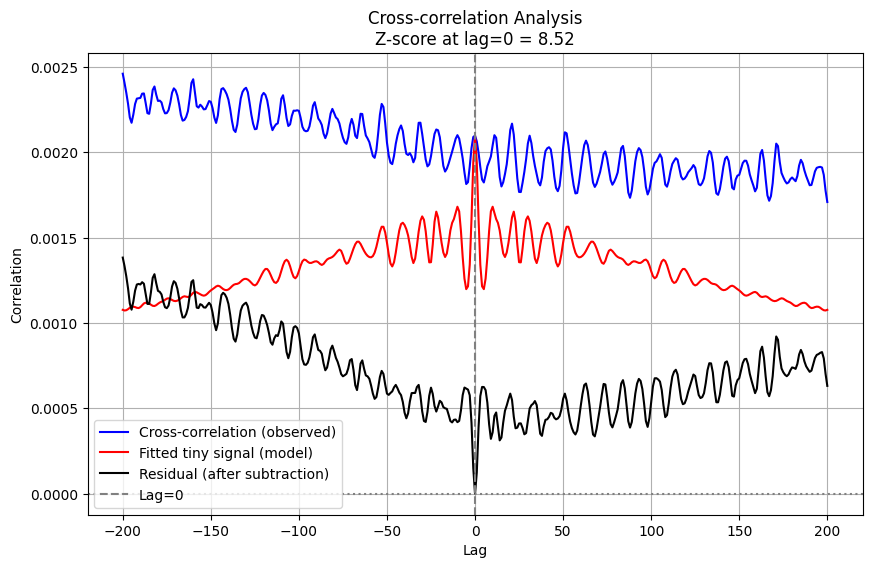

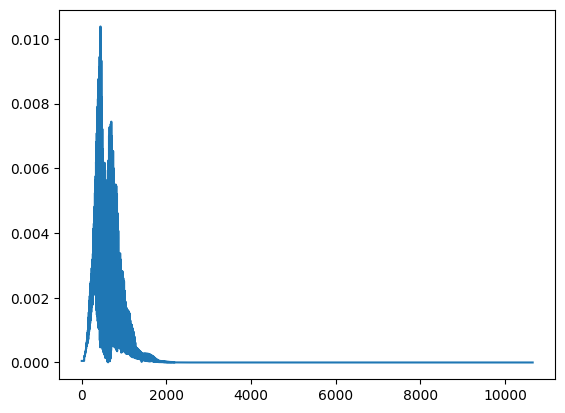

atomic 0.0
C2H2 0.0
CH4 0.010600000000000054
CO 0.00029999999999996696
CO2 0.0
H2O 0.0
HCN 0.0
NH3 0.97
NO 0.3227
OH 0.0


In [8]:
# --- Load your data here ---
# Big_signal: the data containing strong signals + tiny signal + noise
# Tiny_signal: the small signal template you want to find

# Example placeholder (replace these with your real data arrays)
Big_signal = flux_cont_sub[feature_mask]
Tiny_signal = avg_flux[target][feature_mask]

# --- Parameters ---
window = 200   # How far from lag=0 to consider for fitting
exclude = 20   # How many lags around lag=0 to ignore when estimating noise

# --- 1. Compute cross-correlation ---
lags = np.arange(-len(Big_signal) + 1, len(Big_signal))
cross_corr = correlate(Big_signal, Tiny_signal, mode='full')

# --- 2. Compute autocorrelation of tiny signal ---
auto_corr = correlate(Tiny_signal, Tiny_signal, mode='full')
auto_corr = auto_corr / np.max(auto_corr)  # Normalize

# --- 3. Fit autocorrelation to cross-correlation near lag=0 ---
center = len(lags) // 2  # Index corresponding to lag=0
lag_indices = np.arange(center - window, center + window + 1)

X = auto_corr[lag_indices]    # Template (tiny signal autocorrelation)
Y = cross_corr[lag_indices]   # Observed cross-correlation

def model_fn (x,beta):
    shifted_array = shift_array(X, int(round(0)))
    return beta*shifted_array

# Model the expected contribution
popt, pcov = curve_fit(model_fn, lag_indices, Y, p0=[.1])


shift = 0

model = cross_corr[center+shift]*shift_array(X, int(round(shift)))
# Residual
residual = Y - model

# --- 4. Estimate noise standard deviation ---
lags_window = lags[lag_indices] - lags[center]  # Recenter lags around 0

# Mask out ±exclude region around lag=0
noise_mask = (lags_window < -exclude) | (lags_window > exclude)
sigma_noise = np.std(residual[noise_mask])

# --- 5. Calculate Z-score at lag=0 ---
lag0_idx_in_window = np.where(lags_window == 0)[0][0]
Z = cross_corr[center+shift] / sigma_noise

print(f"\nCorrected Z-score at lag=0: {Z:.2f}")
print(f"p-value: {1 - norm.cdf(Z):.4e}")

# --- 6. Plot for visualization ---
plt.figure(figsize=(10,6))
plt.plot(lags_window, Y, label='Cross-correlation (observed)', color='blue')
plt.plot(lags_window, model, label='Fitted tiny signal (model)', color='red')
plt.plot(lags_window, residual, label='Residual (after subtraction)', color='black')
plt.axvline(0, color='gray', linestyle='--', label='Lag=0')
plt.axhline(0, color='gray', linestyle=':')
plt.title(f'Cross-correlation Analysis\nZ-score at lag=0 = {Z:.2f}')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.show()
plt.plot(avg_flux[target])
plt.show()
for target in species:
    print(target, new_detect_molecule(wavelength, flux_cont_sub, avg_flux[target], clip_min=4.9, clip_max=27.5, peak_shift=0, window=500, exclude=300))

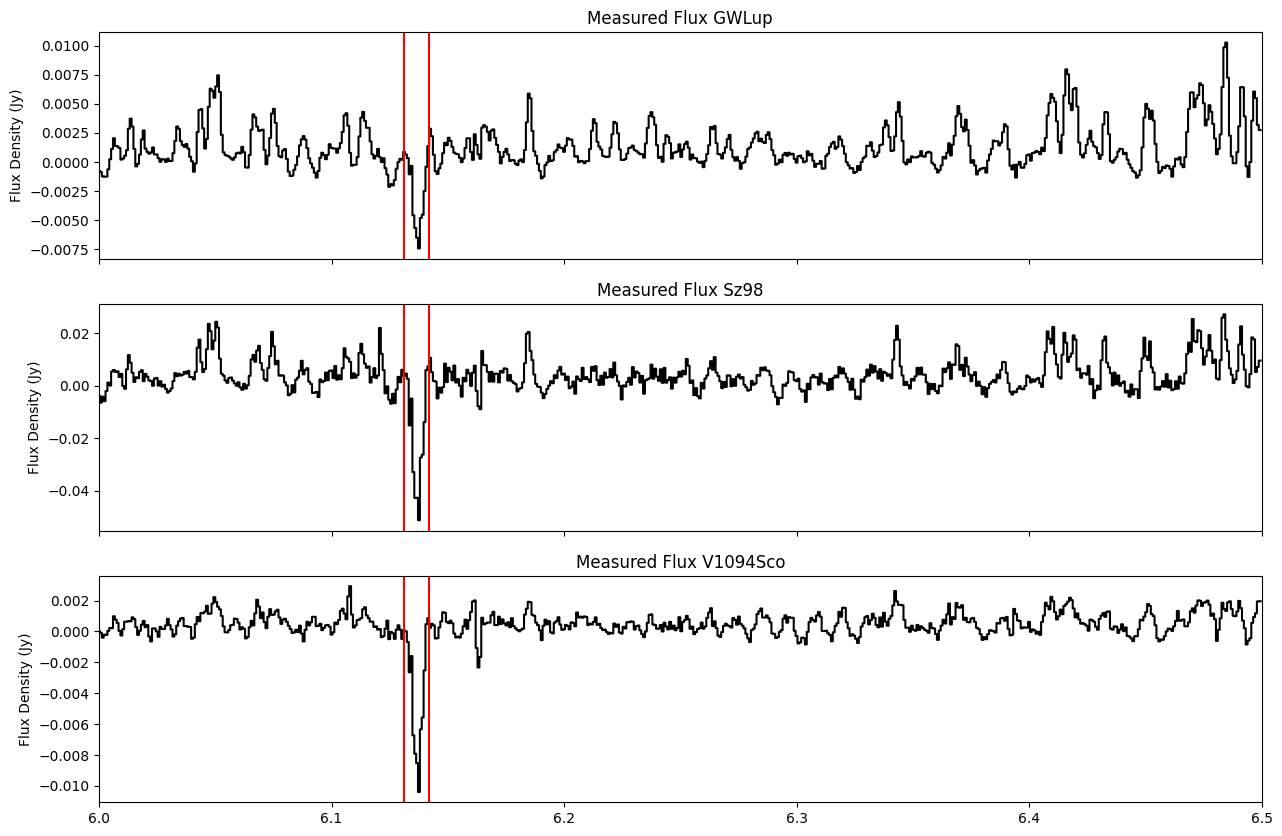

In [9]:
clip_min, clip_max = 6, 6.5
feature_mask = np.logical_and(total_wl > clip_min, total_wl < clip_max)
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
for i, Source in enumerate(['GWLup', 'Sz98', 'V1094Sco']):
    file = f'FullSpectrum_CS_{Source}.p'
    data = pickle.load(open(file, 'rb'))
    wavelength = data['Wavelength']
    flux = data['Flux']
    flux_cont_sub = data['CSFlux']
    continuum = data['Baseline']

    # plt.figure(figsize=(15, 5))
    # ax1.plot(wavelength, model(best_params), color='red')
    # for i, specie in enumerate(species):
    #     ax1.plot(total_wl[feature_mask], best_params[i]*avg_flux[specie][feature_mask], alpha=0.7, label=specie)
    axes[i].step(wavelength[feature_mask], flux_cont_sub[feature_mask], color='black', label=Source)
    axes[i].set_xlim(clip_min, clip_max)
    axes[i].set_ylabel('Flux Density (Jy)')
    axes[i].set_title(f'Measured Flux {Source}')
    axes[i].axvline(6.1311, color='red')
    axes[i].axvline(6.1421, color='red')
    # axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

4.900400095357327 6.259599832264939
1750
4.900400095357327 6.259599832264939
1750


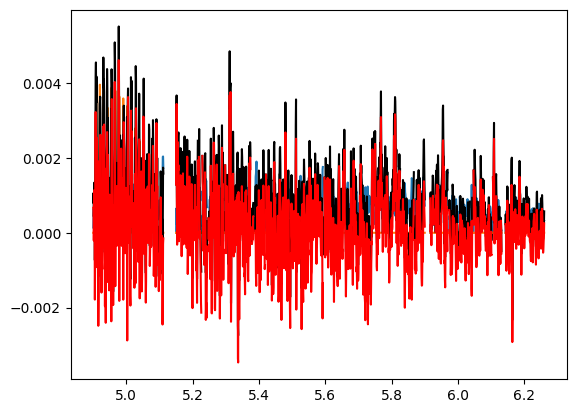

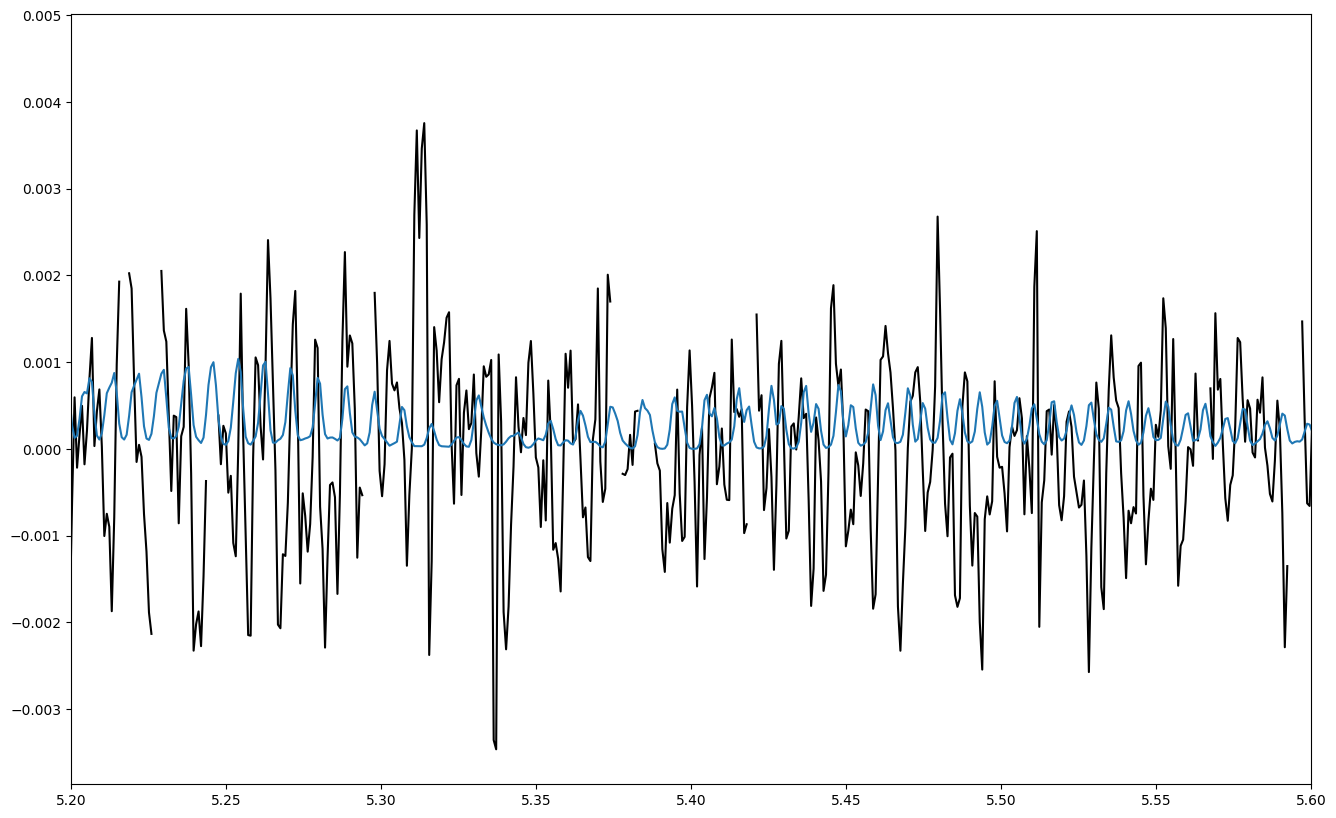

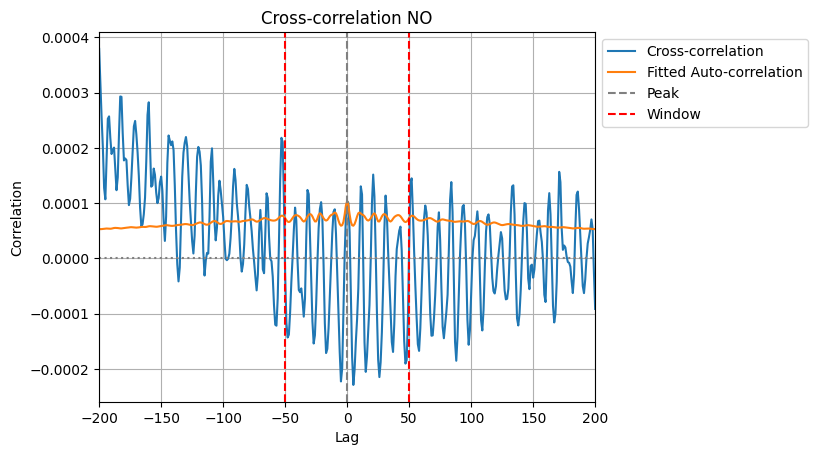

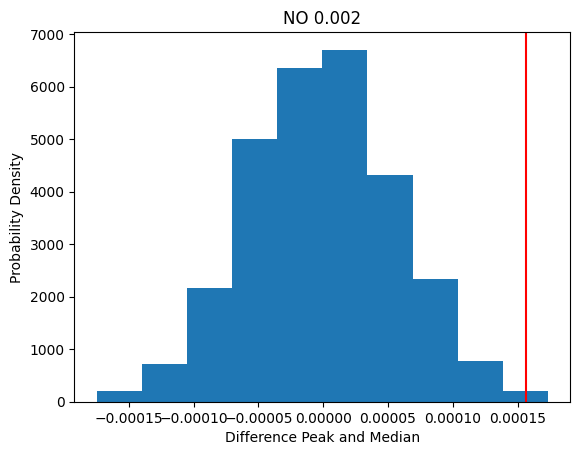

0.002


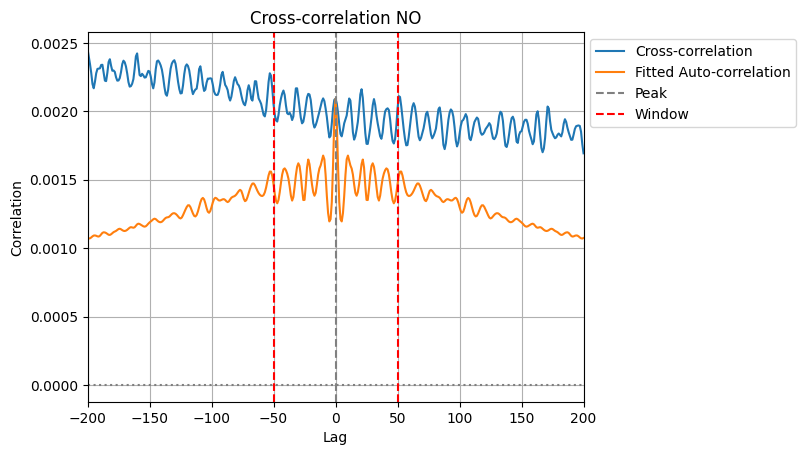

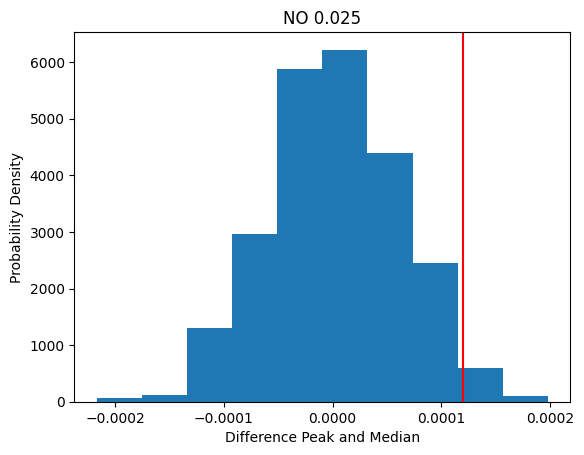

0.025


In [15]:
def mask_regions(wavelength, flux, regions):
    new_flux = flux.copy()
    for region in regions:
        new_flux[np.logical_and(wavelength > region[0], wavelength < region[1])] = np.nan
    return new_flux

artefact_regions = [[5.0091,5.01071], [5.018,5.019], [5.112,5.15],
[5.2157,5.2184], [5.2267,5.2290], [5.2441,5.2471],
[5.2947,5.2974], [5.3742,5.3777], [5.3836,5.3877],
[5.4181,5.4210], [5.5644,5.5674], [5.5925,5.5966],
[5.8252,5.8267], [5.8669,5.8689], [5.9,5.916], [5.9282,5.9314],
[5.9691,5.9728], [6.0357,6.0394], [6.0430,6.0462],
[6.1012,6.1044], [6.1311,6.1421], [6.26,6.31], [6.3740,6.3757],
[6.3783,6.3810], [18.8055,18.8145], [19.004,19.012],
[21.974,21.985], [25.69824,25.71313]]


Source = ['GWLup', 'Sz98', 'V1094Sco'][2]

file = f'FullSpectrum_CS_{Source}.p'
data = pickle.load(open(file, 'rb'))
wavelength = data['Wavelength']
flux_cont_sub = data['CSFlux']
clip_min, clip_max = 4.9, 6.3  # micron

mask = np.ones_like(wavelength, dtype=bool)
for start, end in artefact_regions:
    mask &= ~((wavelength >= start) & (wavelength <= end))

clip_cnd = ((wavelength >= clip_min) & (wavelength <= clip_max))
total = flux_cont_sub[clip_cnd].copy()
for mol in ['H2O', 'CO']:
    file = f'{Source}4_9_6_3/{mol}_best_fit.p'
    data = pickle.load(open(file, 'rb'))
    o_w = data['o_w']
    # o_w = np.nan_to_num(o_w, nan=0)
    print(min(o_w), max(o_w))
    m_f = data['m_f']
    m_f = np.nan_to_num(m_f, nan=0)
    print(len(data['o_w']))
    plt.plot(o_w, mask_regions(o_w, m_f*data['Rdisk_best']**2, artefact_regions))
    total-=m_f*data['Rdisk_best']**2
plt.plot(wavelength[clip_cnd], mask_regions(wavelength[clip_cnd], flux_cont_sub[clip_cnd], artefact_regions), color='black')
plt.plot(wavelength[clip_cnd], mask_regions(wavelength[clip_cnd], total, artefact_regions), color='r')
# plt.xlim(clip_min, clip_max)
plt.show()
plt.figure(figsize=(16,10))
plt.plot(wavelength[clip_cnd], mask_regions(wavelength[clip_cnd], total, artefact_regions), color='black')
plt.plot(wavelength[clip_cnd], avg_flux['NO'][clip_cnd]/10)
plt.xlim(5.2, 5.6)
plt.show()
print(new_detect_molecule(wavelength[clip_cnd], total, avg_flux['NO'][clip_cnd], clip_min, clip_max, title='NO', window=200, exclude=50, plot=True))
print(new_detect_molecule(wavelength[clip_cnd], flux_cont_sub[clip_cnd], avg_flux['NO'][clip_cnd], clip_min, clip_max, title='NO', window=200, exclude=50, plot=True))